### Importar las librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
import tensorflow as tf
from skimage.color import rgb2gray
%matplotlib inline
import os
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import rescale
from PIL import Image, ImageOps
import json
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Importar el dataset desde Github

In [2]:
# Acceder a repo de Github
! rm -rf dataset-food
! git clone https://github.com/brokenerk/dataset-food.git
! ls

Cloning into 'dataset-food'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 3343 (delta 0), reused 1 (delta 0), pack-reused 3342
Receiving objects: 100% (3343/3343), 940.00 MiB | 38.32 MiB/s, done.
Resolving deltas: 100% (256/256), done.
Checking out files: 100% (2704/2704), done.
dataset-food  sample_data


### Clases y cantidad de imágenes por cada una
#### Resumen del dataset

In [3]:
path = './dataset-food/'
classes = []
jsons = []
for f in os.listdir(path):
  if(f != "README.md" and f != ".git" and f != 'pickles'):
    classes.append(f)
classes.sort()

print("Total clases: " + str(len(classes)))
print("Cantidad de imagenes por platillo\n")

for f in classes:
  imagenes = os.listdir(path + f)
  for i in imagenes:
    if(i.find("json") != -1 or i.find("JSON") != -1):
      jsons.append(i)
    
  print(f + ": " + str(len(imagenes) - 1))
  del imagenes

jsons.sort()

Total clases: 53
Cantidad de imagenes por platillo

Birria: 50
BurritoArrachera: 50
CamaronesEmpanizadosAlCoco: 50
ChicharronPreparado: 50
ChongoZamorano: 50
CoctelCamaron: 50
ElotePreparado: 50
EnchiladasHuastecas: 50
EnchiladasVerdes: 50
GorditaChicharron: 50
Guacamole: 50
HuevosRancheros: 50
Milanesa: 50
Mixiote: 50
MojarraMojoAjo: 50
MoleDeOlla: 50
MolePoblano: 50
Molletes: 50
Pambazos: 50
Picadillo: 50
PicoGallo: 50
Pozol: 50
Pozole Verde: 50
QuesadillasDePollo: 50
Sopes: 50
TacosAlPastor: 50
TacosDorados: 50
TamalesOaxaqueños: 50
TampiqueñaRes: 50
Tlacoyos: 50
TortaAhogada: 50
Tostadas: 50
ajoComino: 50
arrozRojo: 50
chicharronSalsaVerde: 50
chilaquilesverdes: 50
chilesEnNogada: 50
chilesRellenos: 50
cochinitaPibil: 50
enfrijoladas: 50
esquites: 50
frijolesOlla: 50
huaraches: 50
huevosalamexicana: 50
panDeMuerto: 50
pastel azteca: 50
pechugaasada: 50
pescadoVeracruzana: 50
pozoleRojo: 50
romeritos: 50
tingaDePollo: 50
tlayudas: 50
verduras salteadas: 50


### Codificacion Onehot para las clases (platillos)
*   Conversión del vector onehot a arreglo de numpy y float32



In [4]:
# Onehot encode
classes_onehot = np.array(classes)
onehot_encoder = OneHotEncoder(sparse = False)
classes_onehot = classes_onehot.reshape(len(classes_onehot), 1)
classes_onehot = onehot_encoder.fit_transform(classes_onehot).astype('float32')

classes_onehot.shape

(53, 53)

### Data Augmentation
Las variantes que se generan por cada imágen válida ya preprocesada son:

*   Volteada a la izquierda (espejo)
*   Volteada de cabeza
*   Volteada de cabeza espejo (volteada a la izquierda)
*   Saturación de color a todas las anteriores (3)
*   Saturación de color a la imágen original

Dando un total de 7 variaciones por imágen, más la imágen preprocesada original (8 en total)

0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0


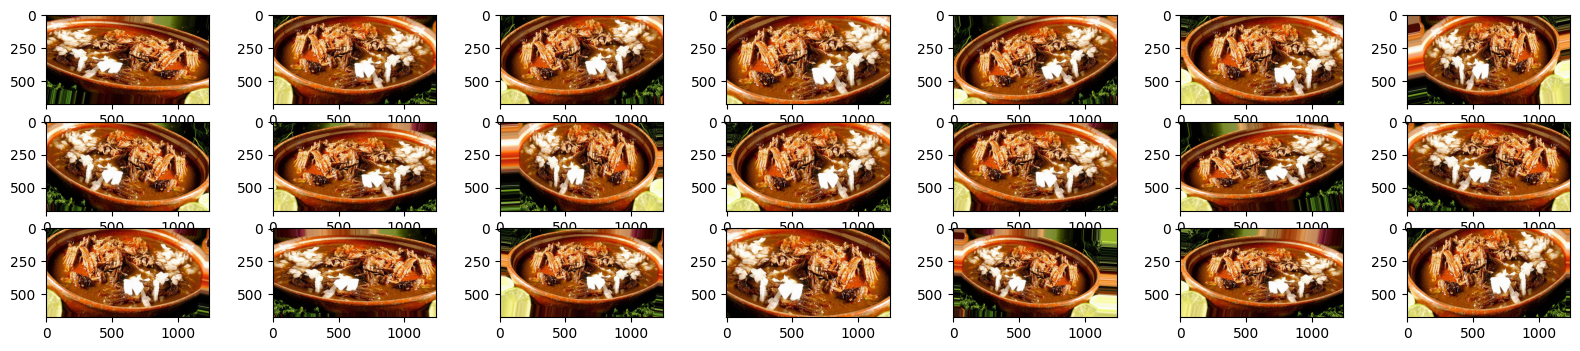

In [19]:
def dataAugmentation(image):
  aug = ImageDataGenerator(featurewise_center=False,
                          samplewise_center=False,
                          featurewise_std_normalization=False,
                          samplewise_std_normalization=False,
                          zca_whitening=False,
                          rotation_range=10,
                          width_shift_range=0.05,
                          height_shift_range=0.05,
                          shear_range=0.1,
                          zoom_range=0.2,
                          channel_shift_range=0.,
                          fill_mode='nearest',
                          cval=0.,
                          horizontal_flip=True,
                          vertical_flip=False)
  
  da =  aug.flow(
        image[None],
        batch_size=8)

  return da

img = Image.open('./dataset-food/Birria/Birria02.jpg')

dataAug = dataAugmentation(np.array(img))
fig, axes = plt.subplots(nrows = 3, ncols = 7, figsize = (20, 4), dpi = 100)
cont = 0
cont2 = 0
cont3 = 0

for da in dataAug:
  da = np.squeeze(da, axis=0) / 255
  if(cont3 > 21 or cont == 3):
    break
  axes[cont][cont2].imshow(da)
  if(cont2 == 6):
    cont2 = 0
    cont += 1
  else:
    cont2 += 1
  cont3 += 1

### Preprocesamiento de imágenes y JSON

*   Dimensiones de la imágen
*   Lectura de JSONS
*   Revisión de canales de color para RGB
*   Aplicación de proporcion rectangular o cuadrada
*   Las imagenes se REESCALAN a un tamaño de 300x300
*   Aplicación de filtros: escala de grises y bordes como canales adicionales
*   Aplicacion de data augmentation
*   Manejo de archivos corruptos (json e imágenes)

In [ ]:
def getDimensions(folder, imagenes, proporcion):
  if(proporcion):
    # Rectangular
    width = 640
    height = 480
  else:
    # Cuadrado
    width = 500
    height = 500
    
  return (width, height)

In [ ]:
def preprocesarImagen(folder, imagenes, proporcion, cont, rgb, escalaGrises, bordes, applyDataAugmentation):
  preprocessed = []
  width, height = getDimensions(folder, imagenes, proporcion)
  dim = 5

  for i in imagenes:
    # Lectura del JSON
    if(i.find("json") != -1 or i.find("JSON") != -1):
      try:
        with open(path + folder + '/' + i, encoding = "utf-8") as json_file: 
          dict = json.load(json_file)
          receta = [classes_onehot[cont], dict]
          listaIngredientes.append(receta)
        continue
      except:
        print("Error al leer JSON " + i + ". Ignorando..")
        continue
    
    # Lectura de la imagen
    try:
      img = Image.open(path + folder + '/' + i)
    except:
        print("Imagen corrupta, ignorando: " + i)
        continue
    
    w, h = img.size
    
    w_pixels = abs(w - width)
    h_pixels = abs(h - height)

    # Se aplica la proporcion rectangular o cuadrada
    if(h < height and w < width):
      border = (int(w_pixels / 2), int(h_pixels / 2), int(w_pixels / 2), int(h_pixels / 2))
      img = ImageOps.expand(img, border)
    elif(h < height and w > width):
      border = (int(w_pixels / 2), 0, int(w_pixels / 2), 0)
      img = ImageOps.crop(img, border)
      border = (0, int(h_pixels / 2), 0, int(h_pixels / 2))
      img = ImageOps.expand(img, border)
    elif(h > height and w < width):
      border = (int(w_pixels / 2), 0, int(w_pixels / 2), 0)
      img = ImageOps.expand(img, border)
      border = (0, int(h_pixels / 2), 0, int(h_pixels / 2))
      img = ImageOps.crop(img, border)
    elif(h > height and w > width):
      border = (int(w_pixels / 2), int(h_pixels / 2), int(w_pixels / 2), int(h_pixels / 2))
      img = ImageOps.crop(img, border)

    # Se hace una segunda revision para eliminar pixeles extras, resultantes de la division 
    # entre 2 de ancho y alto (en numeros nones, por ejemplo, la division no es proporcional)
    w, h = img.size
    w_pixels = w - width
    h_pixels = h - height

    border = (abs(w_pixels), 0, 0, 0)
    if(w_pixels > 0):
      img = ImageOps.crop(img, border)
    elif (w_pixels < 0):
      img = ImageOps.expand(img, border)

    border = (0, abs(h_pixels), 0, 0)
    if(h_pixels > 0):
      img = ImageOps.crop(img, border)
    elif (h_pixels < 0):
      img = ImageOps.expand(img, border)

    # Se revisan los canales para RGB
    canales = img.getbands()

    AImgRGB = np.array(img.convert('RGB'))
    if(len(canales) > 3):
      AImgRGB = AImgRGB[:, :, 0:3]

    # Se reescala la imagen para que sea mas pequeña
    # sin perder proporcion ni calidad
    AImgRGB = AImgRGB.reshape((int(height / dim), dim, int(width / dim), dim, 3)).max(3).max(1)
    AImg = None

    # RGB
    if(rgb):
      AImg = AImgRGB

    # Se aplican y agregan filtros como canales extras
    filtro1 = np.array(img.convert('L'))
    filtro1 = rescale(filtro1, 1 / dim, anti_aliasing = True)
    filtro1 = filtro1.reshape(int(height / dim), int(width / dim))

    # Escala de grises
    if(escalaGrises):
      if(isinstance(AImg, np.ndarray)):
        AImg = np.dstack((AImg, filtro1))
      else:
        AImg = filtro1

    # Bordes
    if(bordes):
      filtro2 = feature.canny(filtro1)
      filtro2 = filtro2.reshape(int(height / dim), int(width / dim))
      if(isinstance(AImg, np.ndarray)):
        AImg = np.dstack((AImg, filtro2))
      else:
        AImg = filtro2

    preprocessed.append(AImg)
    img.close()

  return preprocessed

In [ ]:
!rm -rf pickles/
!mkdir pickles/
%cd pickles/
path = './../' + path

/content/pickles


### Preparación y serialización de los datos 

*   Selección de proporcion. Rectangular = True. Cuadrado = False.
*   Selección de filtros
*   Selección de data augmentation
*   Normalización de las imágenes
*   Conversión de imágenes a arreglos de numpy y float32
*   Generación de lista imágen + clase onehot
*   Generación de lista clase onehot + JSON (dicccionario)
*   Generación de pickles de imágen + clase onehot menores a 2GB

In [ ]:
listaPlatillos = []
listaIngredientes = []
rgb = True
escalaGrises = False
bordes = False
proporcion = False # Rectangular = True. Cuadrado = False
applyDataAugmentation = True
index = 0
cont = 0
batch = 15
y = []
x = []
numDA = 20

if(proporcion):
  print("Proporcion RECTANGULAR")
else:
  print("Proporcion CUADRADA")

# Recorre todas las clases
for c in classes:
  if(c == 'pickles'):
    continue
  # Obtiene las imagenes y JSON de cada clase
  imagenes = os.listdir(path + c)
  imagenes.sort()
  # Preprocesamiento de los archivos
  preprocessed = preprocesarImagen(c, imagenes, proporcion, index, rgb, escalaGrises, bordes, applyDataAugmentation)
  del imagenes

  # Se recorren las imagenes de la clase pre procesadas
  for p in preprocessed:
    # Se agrega la imagen y su clase onehot
    p = p.astype('float32') / 255

    # Data Augmentation
    if(applyDataAugmentation):
      contAug = 0
      for aug in dataAugmentation(p):
        aug = np.squeeze(aug, axis=0)
        aug = aug.astype('float32')
        platillo = [aug, classes_onehot[index]]
        listaPlatillos.append(platillo)
        del platillo
        contAug += 1
        if contAug > numDA:
          break

    platillo = [p, classes_onehot[index]]
    listaPlatillos.append(platillo)
    del platillo
    tam = p.shape
  
  print(str(index) + " " + c + " Imagenes total: " + str(len(preprocessed) + (contAug * len(preprocessed))) + " Tam: " + str(tam))

  # Se van guardando las imagenes en archivos pickles
  # por partes, segun el tam de batch
  if(index == len(classes) - 1):
    f = open('pickle_imagenes' + str(cont), 'wb')
    print("Escribiendo pickle " + str(cont))
    pickle.dump(listaPlatillos, f)
    print(str(len(listaPlatillos)))
    f.close()
    listaPlatillos.clear()
    cont += 1

   # Ultima parte en pickle
  if((index + 1) % batch == 0 and cont < int((len(classes) / batch))):
    f = open('pickle_imagenes' + str(cont), 'wb')
    print("Escribiendo pickle " + str(cont))
    pickle.dump(listaPlatillos, f)
    print(str(len(listaPlatillos)))
    f.close()
    listaPlatillos.clear()
    cont += 1
  index += 1

Proporcion CUADRADA
0 Birria Imagenes total: 1100 Tam: (100, 100, 3)
1 BurritoArrachera Imagenes total: 1100 Tam: (100, 100, 3)
2 CamaronesEmpanizadosAlCoco Imagenes total: 1100 Tam: (100, 100, 3)
3 ChicharronPreparado Imagenes total: 1100 Tam: (100, 100, 3)
4 ChongoZamorano Imagenes total: 1100 Tam: (100, 100, 3)


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


5 CoctelCamaron Imagenes total: 1100 Tam: (100, 100, 3)
6 ElotePreparado Imagenes total: 1100 Tam: (100, 100, 3)
7 EnchiladasHuastecas Imagenes total: 1100 Tam: (100, 100, 3)
8 EnchiladasVerdes Imagenes total: 1100 Tam: (100, 100, 3)
9 GorditaChicharron Imagenes total: 1100 Tam: (100, 100, 3)
10 Guacamole Imagenes total: 1100 Tam: (100, 100, 3)
11 HuevosRancheros Imagenes total: 1100 Tam: (100, 100, 3)
12 Milanesa Imagenes total: 1100 Tam: (100, 100, 3)
13 Mixiote Imagenes total: 1100 Tam: (100, 100, 3)
14 MojarraMojoAjo Imagenes total: 1100 Tam: (100, 100, 3)
Escribiendo pickle 0
16500
15 MoleDeOlla Imagenes total: 1100 Tam: (100, 100, 3)
16 MolePoblano Imagenes total: 1100 Tam: (100, 100, 3)
17 Molletes Imagenes total: 1100 Tam: (100, 100, 3)
18 Pambazos Imagenes total: 1100 Tam: (100, 100, 3)
19 Picadillo Imagenes total: 1100 Tam: (100, 100, 3)
20 PicoGallo Imagenes total: 1100 Tam: (100, 100, 3)
21 Pozol Imagenes total: 1100 Tam: (100, 100, 3)
22 Pozole Verde Imagenes total: 1100 T

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


30 TortaAhogada Imagenes total: 1100 Tam: (100, 100, 3)
31 Tostadas Imagenes total: 1100 Tam: (100, 100, 3)
32 ajoComino Imagenes total: 1100 Tam: (100, 100, 3)
33 arrozRojo Imagenes total: 1100 Tam: (100, 100, 3)
34 chicharronSalsaVerde Imagenes total: 1100 Tam: (100, 100, 3)
35 chilaquilesverdes Imagenes total: 1100 Tam: (100, 100, 3)
36 chilesEnNogada Imagenes total: 1100 Tam: (100, 100, 3)
37 chilesRellenos Imagenes total: 1100 Tam: (100, 100, 3)
38 cochinitaPibil Imagenes total: 1100 Tam: (100, 100, 3)
39 enfrijoladas Imagenes total: 1100 Tam: (100, 100, 3)
40 esquites Imagenes total: 1100 Tam: (100, 100, 3)
41 frijolesOlla Imagenes total: 1100 Tam: (100, 100, 3)
42 huaraches Imagenes total: 1100 Tam: (100, 100, 3)
43 huevosalamexicana Imagenes total: 1100 Tam: (100, 100, 3)
44 panDeMuerto Imagenes total: 1100 Tam: (100, 100, 3)
Escribiendo pickle 2
16500
45 pastel azteca Imagenes total: 1100 Tam: (100, 100, 3)
46 pechugaasada Imagenes total: 1100 Tam: (100, 100, 3)
47 pescadoVera

##### En total los datos se dividen en 53 clases (platillos)

##### Cada clase posee 50 imágenes. Un total de 2650 imágenes.

##### Si se aplica data augmentation, cada clase posee 400 imágenes. Un total de 21200 imágenes.

##### El numero de canales depende de los filtros aplicados.

##### Si se deja solo en RGB, son 3. 
##### Si se aplican los filtros de escala de grises y deteccion de bordes, son 5.


*   Generación de pickle de clase + JSON menor a 2GB

In [ ]:
f = open('pickle_jsons', 'wb')
print("Escribiendo pickle jsons")
pickle.dump(listaIngredientes, f)
f.close()

!ls

Escribiendo pickle jsons
pickle_imagenes0  pickle_imagenes2  pickle_jsons
pickle_imagenes1  pickle_imagenes3


### Escritura de archivos serializados pickles en Drive


In [ ]:
#Nota: Utilizar cuenta vacia para guardar pickles
# Email: colaboratory22@gmail.com
# Password: colaboratory22
from google.colab import drive
drive.mount('/content/gdrive')

%cd ..
!cp -R pickles '/content/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content


### Muestra de los datos preprocesados
Matriz de una imágen de un platillo junto a su clase onehot

In [ ]:
listaPlatillos = []
f = open('pickle_imagenes0', 'rb')
listaPlatillos = listaPlatillos + pickle.load(f, encoding='bytes')
print("pickle_imagenes0 leido");
f.close()
listaPlatillos[0]

/content/pickles
pickle_imagenes0 leido


[array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 

Tamaño de la lista de platillos

In [ ]:
len(listaPlatillos)

16500

#### Imagen a color RGB - 3 canales [Canales 0 - 2]

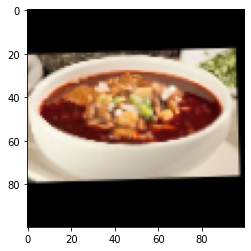

In [ ]:
imagenMuestra = listaPlatillos[0][0]
plt.imshow(imagenMuestra)

Los ingredientes del platillo seleccionado, a modo de diccionario, junto a su clase onehot

In [ ]:
listaIngredientes[0]

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=float32),
 {'Birria': [{'Calorias': 54,
    'Cantidad': '125',
    'Ingrediente': 'Carne de res'},
   {'Calorias': 87, 'Cantidad': '125', 'Ingrediente': 'Pulpa de res'},
   {'Calorias': 2, 'Cantidad': '3/4', 'Ingrediente': 'Agua'},
   {'Calorias': 23, 'Cantidad': '12', 'Ingrediente': 'Chiles secos'},
   {'Calorias': 8, 'Cantidad': '5', 'Ingrediente': 'Chile cascabel'},
   {'Calorias': 22,
    'Cantidad': '1',
    'Ingrediente': 'Jitomate guaje o saladet'},
   {'Calorias': 5, 'Cantidad': '3/8', 'Ingrediente': 'Ajo en polvo'},
   {'Calorias': 7, 'Cantidad': '1/16', 'Ingrediente': 'Comino'},
   {'Calorias': 5, 'Cantidad': '1/16', 'Ingrediente': 'Pimienta negra'},
   {'Calorias': 6, 'Cantidad': '3/8', 'Ingrediente': 'Clavo de olor'},
   {'Calo

Tamaño lista de Ingredientes por platillo 

In [ ]:
len(listaIngredientes)

53